In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt

# Import RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

pd.set_option('display.max_columns', 144)

In [2]:
stock = pd.read_csv('/Users/k0s00ks/Documents/iRage Capital/Data Science Assignment (Latest)/s1.csv')

# The Problem Statement

After decompressing the file, you would get "s1.csv" file.
This file contains data for one particular stock only and has the following header:
date refers to particular time of at which the data is captured. 
b0/b0_cm and a0/a0_cm refers to top bid and top ask for future and cash segment for the respective stock. 
bidx[0-4] and sidx[0-4] refers to distance from top level for bid/ask bsz[0-4] and 
ssz[0-4] refers to size at that level. There are different features pre-computed ( e.g.. momentum ) 
which are also given. ( e.g.. f1,f2, ... f148 )
30secAhead and 1minAhead are prices 30 seconds and 1 minutes in future. 
These columns should not be used for prediction/classification purpose.

In [5]:
cols = list(stock.columns.values)
print (cols)
nrows, ncols = stock.shape
print ('Number of rows and columns are :',nrows, ncols )

['date', 'b0', 'a0', 'bsz0', 'bidx0', 'sidx0', 'ssz0', 'bsz1', 'bidx1', 'sidx1', 'ssz1', 'bsz2', 'bidx2', 'sidx2', 'ssz2', 'bsz3', 'bidx3', 'sidx3', 'ssz3', 'bsz4', 'bidx4', 'sidx4', 'ssz4', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'b0_cm', 'a0_cm', 'bsz0_cm', 'bidx0_cm', 'sidx0_cm', 'ssz0_cm', 'bsz1_cm', 'bidx1_cm', 'sidx1_cm', 'ssz1_cm', 'bsz2_cm', 'bidx2_cm', 'sidx2_cm', 'ssz2_cm', 'bsz3_cm', 'bidx3_cm', 'sidx3_cm', 'ssz3_cm', 'bsz4_cm', 'bidx4_cm', 'sidx4_cm', 'ssz4_cm', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124

In [6]:
stock.head(5)

,date,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead
0,2016-10-27 09:21:01,6320.0,6327.0,1.0,35.0,35.0,2.0,2.0,25.0,15.0,1.0,1.0,60.0,50.0,1.0,1.0,35.0,20.0,2.0,1.0,65.0,70.0,2.0,3600.0,102.0,102.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,273000.0,252000.0,69000.0,75000.0,6315,6316,0.066667,5,5,0.142,0.154667,10,10,0.033333,1.866667,10,10,0.210667,0.405333,15,15,2.472,0.049333,15,15,0.288,762,33,33,0.603333,0.0,0,0,0.0,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,-7,-1,0,0,0,0,0,0,0,0,134310,153263,30069,23398,6315.624091,6316.609275,420.0,0.602885,1.813623,0.000023,-0.008956,0.741935,0.741935,0.0,0.000791,-0.041667,0.040000,0.124769,-0.065907,0,0,0,0,0.011364,0.225281,0.713782,-0.382476,0.0,0.0,-0.000099,-0.000255,0.000693,0.000537,-9.0,-19.0
1,2016-10-27 09:21:02,6320.0,6326.0,1.0,30.0,30.0,1.0,1.0,25.0,5.0,2.0,1.0,55.0,45.0,1.0,1.0,35.0,20.0,1.0,1.0,60.0,50.0,2.0,3000.0,90.0,90.0,2.0,-1.0,0.0,-1.0,-1.0,-1.0,0.0,-55.0,0.0,1.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,270000.0,255000.0,69000.0,75000.0,6315,6316,0.066667,5,5,0.142,0.017333,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,721,33,33,0.152667,0.0,0,0,0.0,-0.088000,-20,-20,-0.893333,8,3,0,0,0,2,0,0,0,-2,0,0,3,8,0,0,0,0,128104,153089,24363,21715,6315.618479,6316.602517,405.0,0.648711,1.821854,0.073260,-0.004427,0.741935,0.741935,0.0,0.000791,-0.041667,0.028571,0.057468,-0.088854,0,0,0,0,-0.336487,0.298750,0.000000,-0.775236,0.0,0.0,-0.000098,-0.000254,0.000694,0.000538,-9.0,-20.0
2,2016-10-27 09:21:03,6320.0,6326.0,1.0,30.0,30.0,2.0,1.0,20.0,5.0,2.0,1.0,50.0,45.0,1.0,1.0,35.0,20.0,1.0,1.0,55.0,50.0,2.0,3000.0,85.0,85.0,3.0,0.0,0.0,0.0,1.0,0.0,25.0,0.0,1.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,2.0,2.0,2.0,14.0,3.0,0.0,0.0,0.0,0.0,267000.0,258000.0,69000.0,81000.0,6315,6316,0.066667,5,5,0.142,0.284000,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,801,33,33,-0.114000,0.0,0,0,0.0,0.266667,0,0,0.000000,1,52,0,0,0,7,0,0,6,-3,0,0,52,1,0,0,0,0,134504,153089,30763,18697,6315.612922,6316.595805,405.0,0.648725,1.821895,0.000023,-0.004405,0.741935,0.741935,0.0,0.000791,-0.080000,0.017143,0.243955,-0.064623,0,0,0,0,-0.510802,-0.318424,0.652317,1.445756,0.0,0.0,-0.000097,-0.000253,0.000694,0.000539,-8.0,-26.0
3,2016-10-27 09:21:04,6320.0,6326.0,1.0,30.0,30.0,1.0,1.0,10.0,5.0,1.0,1.0,60.0,45.0,1.0,1.0,20.0,20.0,1.0,1.0,65.0,50.0,2.0,3000.0,81.0,81.0,1.0,0.0,0.0,0.0,-1.0,0.0,20.0,0.0,-2.0,5.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,13.0,5.0,0.0,0.0,0.0,0.0,270000.0,252000.0,69000.0,72000.0,6315,6316,0.066667,5,5,0.142,0.154667,10,10,0.033333,1.866667,10,10,0.094667,0.405333,15,15,2.000,0.049333,15,15,0.288,762,33,33,0.015333,0.0,0,0,0.0,-0.129333,0,0,0.000000,11,91,0,1,0,13,0,0,13,-4,0,0,91,11,1,0,241,0,135302,154040,30569,18697,6315.607419,6316.589138,405.0,0.648740,1.821936,0.000023,-0.004382,0.741935,0.741935,0.0,0.000791,-0.021277,0.034483,0.240978,-0.064761,0,0,0,0,0.698877,0.002133,-1.324400,-0.012278,0.0,0.0,-0.000096,-0.000252,0.000695,0.000540,-7.0,-25.0
4,2016-10-27 09:21:05,6320.0,6325.0,1.0,25.0,25.0,2.0,1.0,20.0,5.0,1.0,1.0,45.0,30.0,1.0,1.0,30.0,20.0,1.0,1.0,55.0,45.0,1.0,3000.0,75.0,75.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,-45.

In [7]:
stock.tail()

,date,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead
636947,2016-09-06 14:33:28,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.144667,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.937333,0.000,0,0,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500726,837156,52781,23949,5887.580791,5891.596663,40.0,0.363534,0.373271,0.000000,-0.029026,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.375759,-0.251465,0,0,0,0,0.0,0.001130,0.0,-0.062347,0.0,0.00000,0.000411,-0.000271,0.005829,0.005147,0.0,0.0
636948,2016-09-06 14:33:29,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.144000,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.938000,0.000,0,0,-0.000667,0.000000,0,0,-0.000667,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,500626,837156,52481,23949,5887.600784,5891.594006,40.0,0.363534,0.373271,0.000000,-0.029026,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.373309,-0.251558,0,0,0,0,0.0,0.000370,0.0,-0.006541,0.0,0.00000,0.000407,-0.000271,0.005826,0.005148,0.0,0.0
636949,2016-09-06 14:33:30,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5890,5893,0.188667,15,15,0.143333,0.322667,5,5,0.389333,0.051333,20,20,0.033333,0.238000,10,10,1.609333,2.629333,25,25,0.316,1029,35,35,-0.938667,0.000,0,0,0.000000,0.000000,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500626,837156,52481,23949,5887.620613,5891.591354,45.0,0.361785,0.373271,-0.004823,-0.029025,0.364103,0.6,0.0,0.005418,-0.093333,-0.199385,0.373309,-0.251558,0,0,0,0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000404,-0.000270,0.005822,0.005148,0.0,0.0
636950,2016-09-06 14:33:31,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3126000.0,4683000.0,102000.0,123000.0,5891,5893,0.112667,10,10,0.136667,0.076000,5,5,0.389333,0.322667,15,15,0.033333,0.051333,10,10,1.609333,0.238000,20,20,0.316,240,30,30,1.684000,-0.076,1,0,-0.006667,-2.629333,25,0,-0.006667,0,2,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,10,500625,837156,52480,23949,5887.648541,5891.590370,40.0,0.363534,0.373271,0.004824,-0.029025,0.364103,0.6,0.0,0.005248,-0.093333,-0.199385,0.373301,-0.251559,0,0,0,0,0.0,0.000004,0.0,-0.000021,0.0,0.00017,0.000569,-0.000100,0.005818,0.005148,0.0,0.0
636951,2016-09-06 14:33:32,5922.0,5926.0,2.0,20.0,20.0,1.0,1.0,5.0,10.0,1.0,1.0,25.0,25.0,2.0,1.0,10.0,15.0,1.0,2.0,30.0,30.0,1.0,4200.0,44.0,44.0,-1.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
stock.describe()

,b0,a0,bsz0,bidx0,sidx0,ssz0,bsz1,bidx1,sidx1,ssz1,bsz2,bidx2,sidx2,ssz2,bsz3,bidx3,sidx3,ssz3,bsz4,bidx4,sidx4,ssz4,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,b0_cm,a0_cm,bsz0_cm,bidx0_cm,sidx0_cm,ssz0_cm,bsz1_cm,bidx1_cm,sidx1_cm,ssz1_cm,bsz2_cm,bidx2_cm,sidx2_cm,ssz2_cm,bsz3_cm,bidx3_cm,sidx3_cm,ssz3_cm,bsz4_cm,bidx4_cm,sidx4_cm,ssz4_cm,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,30secAhead,1minAhead,Hour
count,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.00000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,6.369520e+05,6.369520e+05,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000,636952.000000
mean,6018.829987,6023.907466,1.453929,25.387392,25.387392,1.476166,1.554364,7.994354,8.057491,1.616459,1.695360,33.504259,33.522455,1.763649,1.773862,16.732729,16.782293,1.864505,1.799603,42.632789,42.489638,1.932954,4966.270928,58.584440,58.584440,0.376616,-0.003036,0.008921,-0.004459,-0.003192,-0.004540,0.280649,-0.133589,-0.003909,2.246050,2.191237,0.049939,0.041568,0.677038,0.666540,9.024228,8.831121,-1.833498,-2.049679,0.070123,0.067551,2.191237,2.246050,0.041568,0.049939,131.732061,159.157990,2.257804e+06,3.006445e+06,111243.856680,137198.821889,6007.781108,6010.176726,0.319223,11.978093,11.978093,0.260244,0.405890,6.662920,6.810121,0.337748,0.559258,17.614891,17.645309,0.484486,0.757948,12.038113,12.214822,0.656732,0.956588,22.961911,23.085586,0.832749,899.271694,36.008351,36.008351,-0.426948,-0.000220,0.001637,0.007944,0.000625,0.001707,0.046149,0.16327,0.002838,6.237625,5.979895,0.493901,0.412783,0.567724,0.601579,1.193883,2.102673,-7.779666,-8.004014,0.154159,-0.000104,5.979895,6.237625,0.412783,0.493901,40.225654,43.393541,6.172423e+05,6.774426e+05,36321.498078,35141.673931,6007.571278,6006.970744,73.673299,0.377404,2.386418e+02,0.000007,0.012183,0.424381,0.481663,7.881175e-07,0.001918,-0.088929,-0.

Now we will check for the data scantity. Checking if there are any NA values in the data. And we find the data to be clean.

In [12]:
# Check for NA values in the data
labels = []
values = []
for col in stock.columns:
    labels.append(col)
    values.append(stock[col].isnull().sum())
    if (values[-1] !=0):
        print(col, values[-1])

In [82]:
# Convert the Date column to Date and time seperately
stock['date'] = pd.to_datetime(stock['date'])
stock['Time'],stock['Date']= stock['date'].apply(lambda x:x.time()), stock['date'].apply(lambda x:x.date())
stock['Hour'] = stock['date'].apply(lambda x:x.hour)

In [83]:
stock_list = ['b0', 'a0', 'bsz0', 'bidx0', 'sidx0', 'ssz0', 'bsz1', 'bidx1', 'sidx1', 
               'ssz1', 'bsz2', 'bidx2', 'sidx2', 'ssz2', 'bsz3', 'bidx3', 'sidx3', 'ssz3', 
               'bsz4', 'bidx4', 'sidx4', 'ssz4', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 
               'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 
               'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 
               'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'b0_cm', 'a0_cm', 'bsz0_cm', 'bidx0_cm', 
               'sidx0_cm', 'ssz0_cm', 'bsz1_cm', 'bidx1_cm', 'sidx1_cm', 'ssz1_cm', 'bsz2_cm', 'bidx2_cm', 
               'sidx2_cm', 'ssz2_cm', 'bsz3_cm', 'bidx3_cm', 'sidx3_cm', 'ssz3_cm', 'bsz4_cm', 'bidx4_cm',
               'sidx4_cm', 'ssz4_cm', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91',
               'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 
               'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 
               'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 
               'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 
               'f145', 'f146', 'f147', 'f148', '30secAhead', '1minAhead']

corrmat_pearson = stock[stock_list].corr(method='pearson')
corrmat_spearman = stock[stock_list].corr(method='spearman')

# Checking correlations
Let's look at variables having the largest correlation with the '30secAhead' and '1minuteAhead'

In [94]:
# Top list of correlations using pearson correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_pearson['30secAhead'] > 0.08].index) 

# Top list of correlations using spearman correlation
print (corrmat_spearman['30secAhead'].loc[corrmat_spearman['30secAhead'] > 0.08])

Index([u'bidx0', u'sidx0', u'bidx2', u'sidx2', u'bidx4', u'sidx4', u'f26',
       u'f27', u'30secAhead', u'1minAhead'],
      dtype='object')
bidx0         0.173250
sidx0         0.173250
bidx2         0.144299
sidx2         0.156778
bidx4         0.126411
sidx4         0.143512
f26           0.105608
f27           0.105608
30secAhead    1.000000
1minAhead     0.658747
Name: 30secAhead, dtype: float64


In [95]:
# Checking for variables having high negative correlations with the predictor variable

# Top list of correlations using pearson correlation
print (corrmat_pearson['30secAhead'].loc[corrmat_pearson['30secAhead'] < -0.05]) 

# Top list of correlations using spearman correlation
print (corrmat_spearman['30secAhead'].loc[corrmat_spearman['30secAhead'] < -0.05].index)

bidx1   -0.086939
bidx3   -0.064535
Name: 30secAhead, dtype: float64
Index([u'bidx1', u'bidx3', u'bsz2_cm', u'bsz3_cm', u'bsz4_cm', u'f82',
       u'f114'],
      dtype='object')


In [91]:
# We will check for correlations between these extracted variables to check for correlation clustering occuring between them

extracted = list(corrmat_pearson['30secAhead'].loc[corrmat_pearson['30secAhead'] > 0.08].index)
corrmat_new = stock[extracted].corr(method='pearson')

corrmat_new

,bidx0,sidx0,bidx2,sidx2,bidx4,sidx4,f26,f27,30secAhead,1minAhead
bidx0,1.000000,1.000000,0.889920,0.887203,0.800176,0.802042,0.772263,0.772263,0.143704,0.118252
sidx0,1.000000,1.000000,0.889920,0.887203,0.800176,0.802042,0.772263,0.772263,0.143704,0.118252
bidx2,0.889920,0.889920,1.000000,0.796442,0.889621,0.723891,0.796927,0.796927,0.113318,0.093435
sidx2,0.887203,0.887203,0.796442,1.000000,0.718797,0.895927,0.793631,0.793631,0.126984,0.106814
bidx4,0.800176,0.800176,0.889621,0.718797,1.000000,0.656542,0.763755,0.763755,0.098598,0.081383
sidx4,0.802042,0.802042,0.723891,0.895927,0.656542,1.000000,0.763023,0.763023,0.114125,0.096033
f26,0.772263,0.772263,0.796927,0.793631,0.763755,0.763023,1.000000,1.000000,0.082183,0.070468
f27,0.772263,0.772263,0.796927,0.793631,0.763755,0.763023,1.000000,1.000000,0.082183,0.070468
30secAhead,0.143704,0.143704,0.113318,0.126984,0.098598,0.114125,0.082183,0.082183,1.000000,0.700067
1minAhead,0.118252,0.118252,0.093435,0.106814,0.081383,0.096033,0.070468,0.070468,0.700067,1.000000


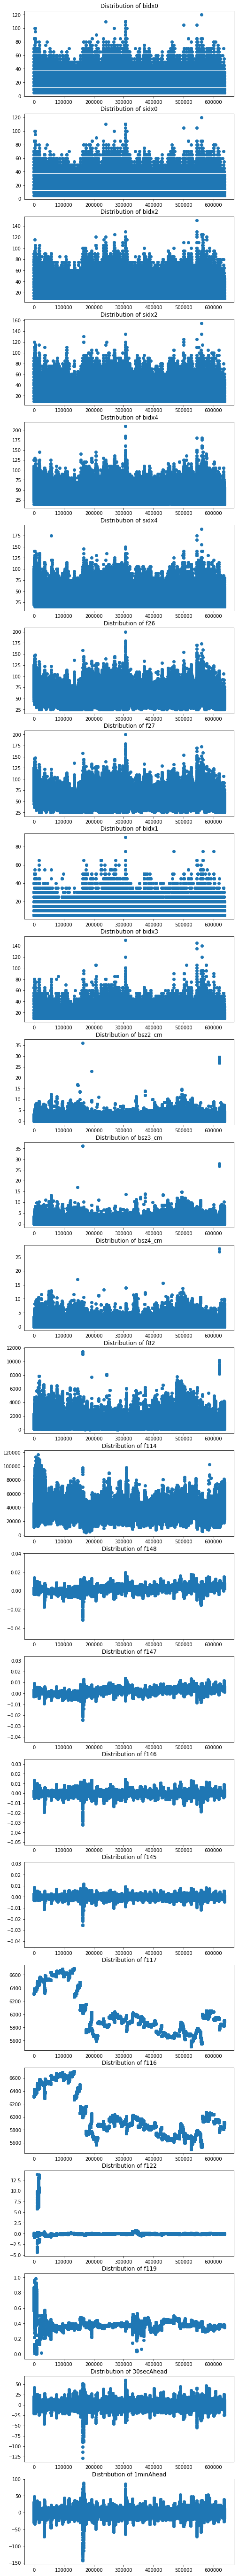

In [100]:
cols_to_use = [u'bidx0', u'sidx0', u'bidx2', u'sidx2', u'bidx4', u'sidx4', u'f26',
       u'f27', u'bidx1', u'bidx3', u'bsz2_cm', u'bsz3_cm', u'bsz4_cm', u'f82',
       u'f114',u'f148', u'f147', u'f146', u'f145', u'f117', u'f116', u'f122', u'f119','30secAhead','1minAhead']
b = len(cols_to_use)
fig = plt.figure(figsize=(8, 100))
plot_count = 0
for colm in cols_to_use:
    plot_count += 1
    plt.subplot(b, 1, plot_count)
    plt.scatter(range(stock.shape[0]), stock[colm].values)
    plt.title("Distribution of "+colm)
plt.show()


Analysing the distribution graphs we have a few points to notice:
    
    1. Distribution of f145, f146, f147, f148 is very similar to 30secAhead and 1minAhead
    2. There is high variation in the starting for f116, f117, f119 and f122.
    3. Distribution of bids features is almost the same with a few visible outliers.
    
Lets plot the frequency distributions for some of these features.

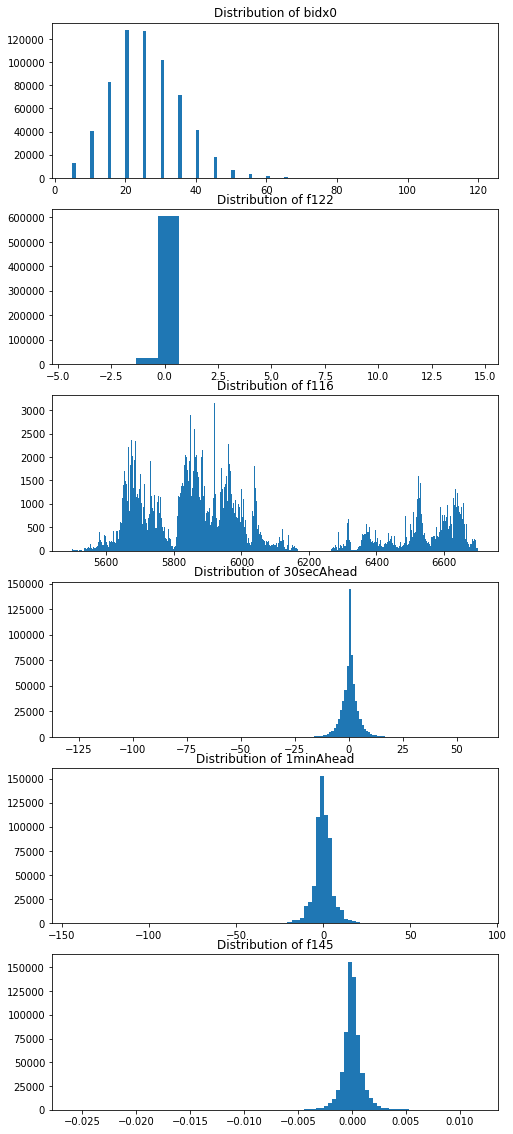

In [105]:
cols_to_use = ['bidx0', 'f122', 'f116', '30secAhead', '1minAhead','f145']
fig = plt.figure(figsize=(8, 20))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(6, 1, plot_count)
    if(plot_count <5):
        plt.hist(stock[col], bins = np.arange(stock[col].min(), stock[col].max()+1))
        plt.title("Distribution of "+ col)
    else :
        plt.hist(stock[col], bins = 100)
        plt.title("Distribution of "+ col)        
plt.show()

The distribution of f145 is very similar to the distribution of 30secAhead an 1minAhead which makes these features very important for modelling. These may act as precessor of the movement in Futures prices.

# Visualising the varition of returns during the day

We observe that during the start and end of the variation are really high. To capture this concept we will keep the hour of the day as a variable in the independent variable space.

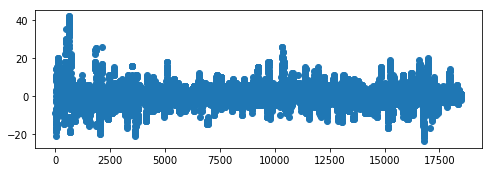

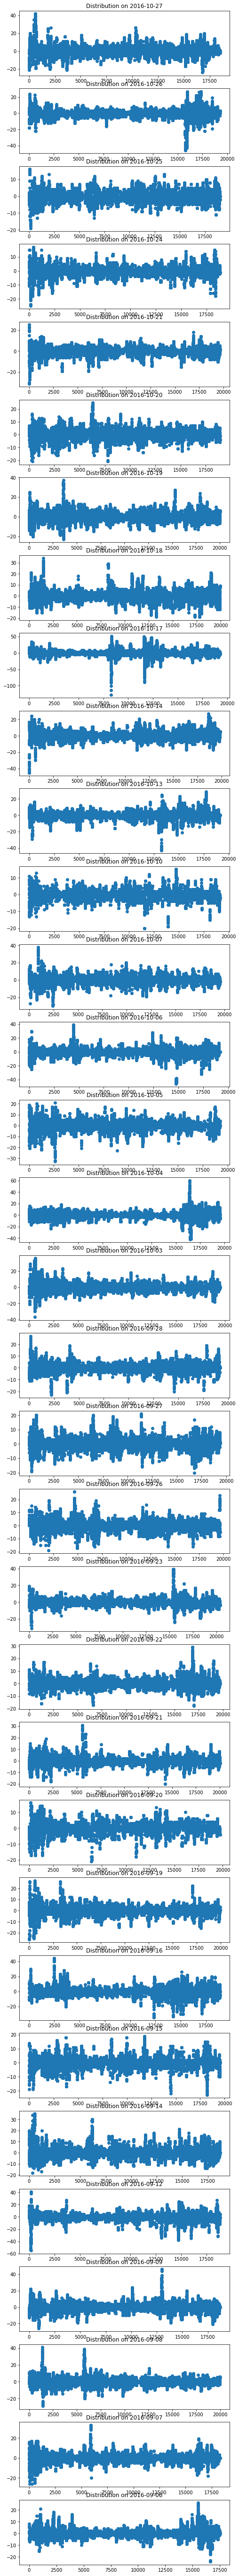

In [112]:
cols_to_use = [u'bidx0', u'sidx0', u'bidx2', u'sidx2', u'bidx4', u'sidx4', u'f26',
       u'f27', u'bidx1', u'bidx3', u'bsz2_cm', u'bsz3_cm', u'bsz4_cm', u'f82',
       u'f114',u'f148', u'f147', u'f146', u'f145', u'f117', u'f116', u'f122', u'f119','30secAhead','1minAhead']

date_list = list(stock['Date'].unique())
b = len(date_list)
fig = plt.figure(figsize=(8, 100))
plot_count = 0
for date in date_list:
    plot_count += 1
    plt.subplot(b, 1, plot_count)
    plt.scatter(range(stock.loc[stock['Date'] == date].shape[0]), stock['30secAhead'].loc[stock['Date'] == date].values)
    plt.title("Distribution on "+ str(date))
plt.show()